In [207]:
import os
from google.colab import drive
# drive.mount('/content/gdrive')

print(os.getcwd())
print(os.listdir('/content/drive/MyDrive/Colab Notebooks'))
os.chdir('/content/drive/MyDrive/Colab Notebooks')
print(os.getcwd())

!pip install jax[cpu]

/content/drive/MyDrive/Colab Notebooks
['differentiation.py', 'plane.npy', 'MATH215', 'lab1_spiral.png', 'lab1.ipynb', 'day02.ipynb', 'lab2.ipynb', 'differentiation.ipynb']
/content/drive/MyDrive/Colab Notebooks
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [208]:
# differentiation.py
"""Volume 1: Differentiation.
Nathan Schill
Section 2
Tues. Jan. 31, 2023
"""

from jax import numpy as jnp
from jax import grad

import numpy as np
import sympy as sy
import matplotlib.pyplot as plt
from time import perf_counter as pc

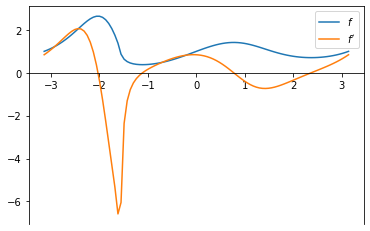

In [209]:
# Problem 1
def prob1():
    """Return the derivative of (sin(x) + 1)^sin(cos(x)) using SymPy."""
    
    # Define x, f(x), f'(x)
    x = sy.symbols('x')
    f = (sy.sin(x) + 1)**sy.sin(sy.cos(x))
    fp = sy.lambdify(x, sy.diff(f, x))

    return fp

### Test
# Define x, f, f'
x = sy.symbols('x')
f = sy.lambdify(x, (sy.sin(x) + 1)**sy.sin(sy.cos(x)))
fp = prob1()

# Plot
domain = np.linspace(-np.pi, np.pi, 100)
plt.plot(domain, f(domain), label='$f$')
plt.plot(domain, fp(domain), label="$f'$")

# Plot properties
ax = plt.gca()
ax.spines['bottom'].set_position('zero')
plt.legend()
plt.show()

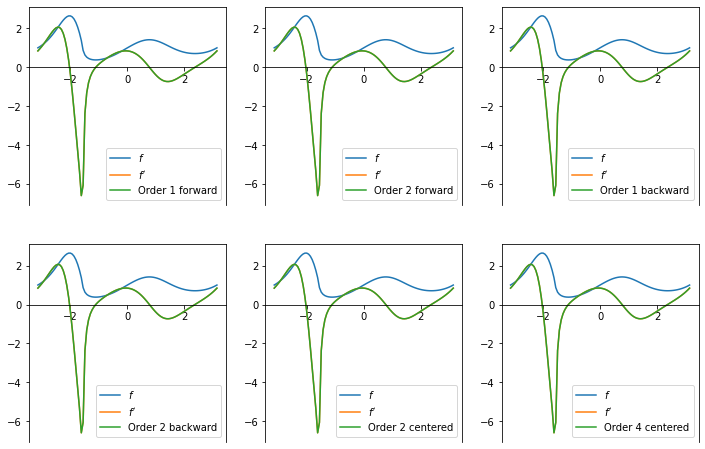

In [210]:
# Problem 2
def fdq1(f, x, h=1e-5):
    """Calculate the first order forward difference quotient of f at x."""
    return (f(x+h) - f(x))/h

def fdq2(f, x, h=1e-5):
    """Calculate the second order forward difference quotient of f at x."""
    return (-3*f(x) + 4*f(x+h) - f(x+2*h))/(2*h)

def bdq1(f, x, h=1e-5):
    """Calculate the first order backward difference quotient of f at x."""
    return (f(x) - f(x-h))/h

def bdq2(f, x, h=1e-5):
    """Calculate the second order backward difference quotient of f at x."""
    return (3*f(x) - 4*f(x-h) + f(x-2*h))/(2*h)

def cdq2(f, x, h=1e-5):
    """Calculate the second order centered difference quotient of f at x."""
    return (f(x+h) - f(x-h))/(2*h)

def cdq4(f, x, h=1e-5):
    """Calculate the fourth order centered difference quotient of f at x."""
    return (f(x-2*h) - 8*f(x-h) + 8*f(x+h) - f(x+2*h))/(12*h)

### Test
# Define x, f(x), f'(x)
x = sy.symbols('x')
f = sy.lambdify(x, (sy.sin(x) + 1)**sy.sin(sy.cos(x)))
fp = prob1()

# Define tuple of difference quotients and tuple of names
fns = (fdq1, fdq2, bdq1, bdq2, cdq2, cdq4)
nms = ('Order 1 forward', 'Order 2 forward', 'Order 1 backward',
       'Order 2 backward', 'Order 2 centered', 'Order 4 centered')

# Domain, fig
domain = np.linspace(-np.pi, np.pi, 100)
fig, axs = plt.subplots(2, 3, figsize=(12,8))
axs = np.ravel(axs)

# Plot f, f', and finite difference quotient together
for ax, fn, nm in zip(axs, fns, nms):
    ax.plot(domain, f(domain), label='$f$')
    ax.plot(domain, fp(domain), label="$f'$")
    ax.plot(domain, fn(f, domain), label=nm)

    ax.legend()
    ax.spines['bottom'].set_position('zero')

plt.show()

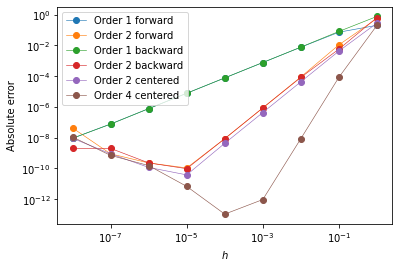

In [211]:
# Problem 3
def prob3(x0):
    """Let f(x) = (sin(x) + 1)^(sin(cos(x))). Use prob1() to calculate the
    exact value of f'(x0). Then use fdq1(), fdq2(), bdq1(), bdq2(), cdq1(),
    and cdq2() to approximate f'(x0) for h=10^-8, 10^-7, ..., 10^-1, 1.
    Track the absolute error for each trial, then plot the absolute error
    against h on a log-log scale.

    Parameters:
        x0 (float): The point where the derivative is being approximated.
    """

    # Define x, f(x), f'(x)
    x = sy.symbols('x')
    f = sy.lambdify(x, (sy.sin(x) + 1)**sy.sin(sy.cos(x)))
    fp = prob1()

    # Define tuple of difference quotients and tuple of names
    fns = (fdq1, fdq2, bdq1, bdq2, cdq2, cdq4)
    nms = ('Order 1 forward', 'Order 2 forward', 'Order 1 backward',
           'Order 2 backward', 'Order 2 centered', 'Order 4 centered')
    
    # h-values
    H = np.logspace(-8, 0, 9)

    # Define array of errors
    # row: difference quotient in same order as fns
    # column: h = 10e-8, ..., 10e0
    err = np.zeros((len(fns), len(H)))
    
    # Calculate error for each fn and each h
    for i, fn in enumerate(fns):
        for j, h in enumerate(H):
            err[i,j] = np.abs(fp(x0) - fn(f, x0, h))
    
    # Plot
    for i, nm in enumerate(nms):
        plt.loglog(H, err[i], label=nm, marker='o', lw=0.6)
    
    # Plot properties
    plt.ylabel('Absolute error')
    plt.xlabel('$h$')
    plt.legend(loc='upper left')
    plt.show()
    
prob3(1)

In [212]:
# Problem 4
def prob4():
    """The radar stations A and B, separated by the distance 500m, track a
    plane C by recording the angles alpha and beta at one-second intervals.
    Your goal, back at air traffic control, is to determine the speed of the
    plane.

    Successive readings for alpha and beta at integer times t=7,8,...,14
    are stored in the file plane.npy. Each row in the array represents a
    different reading; the columns are the observation time t, the angle
    alpha (in degrees), and the angle beta (also in degrees), in that order.
    The Cartesian coordinates of the plane can be calculated from the angles
    alpha and beta as follows.

    x(alpha, beta) = a tan(beta) / (tan(beta) - tan(alpha))
    y(alpha, beta) = (a tan(beta) tan(alpha)) / (tan(beta) - tan(alpha))

    Load the data, convert alpha and beta to radians, then compute the
    coordinates x(t) and y(t) at each given t. Approximate x'(t) and y'(t)
    using a first order forward difference quotient for t=7, a first order
    backward difference quotient for t=14, and a second order centered
    difference quotient for t=8,9,...,13. Return the values of the speed at
    each t.
    """

    # Meters
    a = 500

    # Load degree data, copy to rad array, and convert to radians in rad
    deg = np.load('plane.npy')
    rad = deg.copy()
    np.deg2rad(rad[:,1:], rad[:,1:])

    # Functions for conversion to Cartesian coordinates as given in lab PDF
    cart_x = lambda alpha, beta: a*np.tan(beta)/(np.tan(beta) - np.tan(alpha))
    cart_y = lambda alpha, beta: a*np.tan(beta)*np.tan(alpha)/(np.tan(beta) - np.tan(alpha))

    # Cartesian coordinates at times as in rad
    x = cart_x(rad[:,1], rad[:,2])
    y = cart_y(rad[:,1], rad[:,2])

    # Find x', y' using second-order centered difference quotient for all but endpoint t-values
    xp = np.zeros_like(x)
    yp = np.zeros_like(y)
    xp[1:-1] = (x[2:] - x[0:-2])/2
    yp[1:-1] = (y[2:] - y[0:-2])/2

    # x', y' for endpoint t-values with first-order forward/backward difference quotients
    xp[0] = x[1] - x[0]
    xp[-1] = x[-1] - x[-2]
    yp[0] = y[1] - y[0]
    yp[-1] = y[-1] - y[-2]

    # Calculate speed at each t-value
    speed = (xp**2 + yp**2)**(1/2)

    return speed

prob4()

array([46.42420062, 47.00103938, 48.99880514, 50.09944163, 48.29035084,
       51.56455905, 53.92303355, 51.51480057])

In [213]:

# Problem 5
def jacobian_cdq2(f, x, h=1e-5):
    """Approximate the Jacobian matrix of f:R^n->R^m at x using the second
    order centered difference quotient.

    Parameters:
        f (function): the multidimensional function to differentiate.
            Accepts a NumPy (n,) ndarray and returns an (m,) ndarray.
            For example, f(x,y) = [x+y, xy**2] could be implemented as follows.
            >>> f = lambda x: np.array([x[0] + x[1], x[0] * x[1]**2])
        x ((n,) ndarray): the point in R^n at which to compute the Jacobian.
        h (float): the step size in the finite difference quotient.

    Returns:
        ((m,n) ndarray) the Jacobian matrix of f at x.
    """
    
    def ek(n, k):
        '''Return kth standard basis vector in R^n.''' 
        ek = np.zeros(n)
        ek[k] = 1
        return ek

    # Get n, m, define J
    n = len(x)
    m = len(f(x))
    J = np.zeros((m, n))

    # Get columns of J
    for j in range(n):
        J[:,j] = (f(x + h*ek(n,j)) - f(x - h*ek(n,j)))/(2*h)

    return J

### Test
pt = (0, 0)
x, y = sy.symbols('x y')

# Define f: R2 -> R2
f = lambda x: np.array([x[0]**2, x[0]**3 - x[1]])
ff = sy.Matrix(f(np.array([x,y])))

print(ff.jacobian([x,y]).subs({x:pt[0], y:pt[1]}))

jacobian_cdq2(f, np.array(pt))

Matrix([[0, 0], [0, -1]])


array([[ 0.e+00,  0.e+00],
       [ 1.e-10, -1.e+00]])

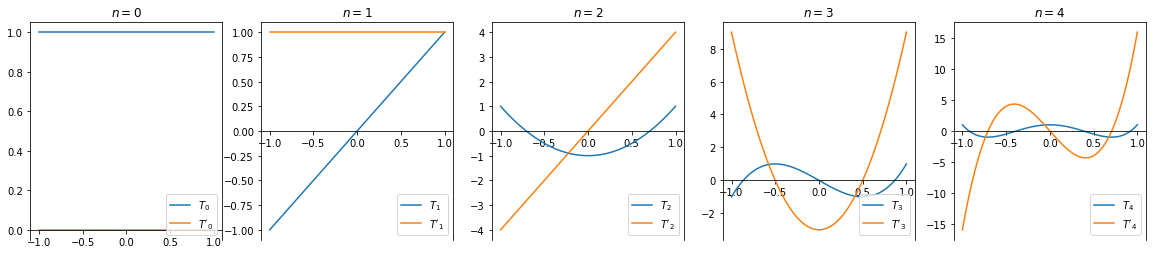

In [218]:
# Problem 6
def cheb_poly(x, n):
    """Compute the nth Chebyshev polynomial at x.

    Parameters:
        x (jax.ndarray): the points to evaluate T_n(x) at.
        n (int): The degree of the polynomial.
    """
    
    # Array for computing and storing Chebyshev polynomials evaluated at x
    T = [jnp.ones_like(x), (lambda t: t)(x)] + [None] * jnp.max(np.array([0, n-1])).item()

    # Recursively compute T_n at x
    for i in range(2, n+1):
        T[i]  = 2*x*T[i-1] - T[i-2]

    return T[n]

def prob6():
    """Use JAX and cheb_poly() to create a function for the derivative
    of the Chebyshev polynomials, and use that function to plot the derivatives
    over the domain [-1,1] for n=0,1,2,3,4.
    """
    
    # Get cheb_poly's gradient; define n to iterate over
    dcheb = np.vectorize(grad(cheb_poly))
    MAX_N = 4
    N = list(range(MAX_N + 1))

    # Get domain, fig
    a, b = -1, 1
    domain = np.linspace(a, b, 100)
    fig, axs = plt.subplots(1, len(N), figsize=(20,4))
    
    for ax, n in zip(axs, N):
        # Plot T_n and T'_n for each n
        ax.plot(domain, cheb_poly(domain, n), label=f'$T_{n}$')
        ax.plot(domain, dcheb(domain, n), label=f'$T\'_{n}$')

        # Plot properties
        ax.set_title(f'$n={n}$')
        ax.legend(loc='lower right')
        ax.spines['bottom'].set_position('zero')

    plt.show()
    
# cheb_poly(np.array([1,2]), 3)
prob6()

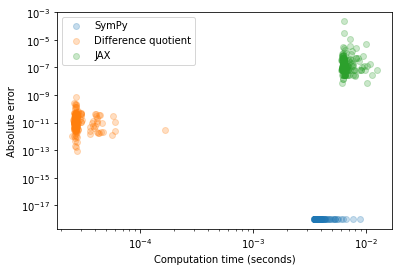

In [217]:
# Problem 7
def prob7(N=200):
    """
    Let f(x) = (sin(x) + 1)^sin(cos(x)). Perform the following experiment N
    times:

        1. Choose a random value x0.
        2. Use prob1() to calculate the "exact" value of f′(x0). Time how long
            the entire process takes, including calling prob1() (each
            iteration).
        3. Time how long it takes to get an approximation of f'(x0) using
            cdq4(). Record the absolute error of the approximation.
        4. Time how long it takes to get an approximation of f'(x0) using
            JAX (calling grad() every time). Record the absolute error of
            the approximation.

    Plot the computation times versus the absolute errors on a log-log plot
    with different colors for SymPy, the difference quotient, and JAX.
    For SymPy, assume an absolute error of 1e-18.
    """

    # Define f
    f = lambda t: (np.sin(t) + 1)**np.sin(np.cos(t))
    jf = lambda t: (jnp.sin(t) + 1)**jnp.sin(jnp.cos(t))

    # Uniform random floats between 0 and MAX_RAND
    MAX_RAND = 10
    x0 = np.random.rand(N)*MAX_RAND

    # Arrays for recording computation time and error for each method
    # Assume sympy err is always 1e-18
    sympy_time = np.zeros(N)
    diff_q_time_err = np.zeros((2,N))
    jax_time_err = np.copy(diff_q_time_err)
    
    for i, x in enumerate(x0):
        # Time SymPy
        start = pc()
        fp = prob1()(x)
        end = pc()
        sympy_time[i] = end - start

        # Time difference quotient and compare with SymPy
        start = pc()
        diff_q = cdq4(f, x)
        end = pc()
        diff_q_time_err[0,i] = end - start
        diff_q_time_err[1,i] = np.abs(fp - diff_q)

        # Time JAX and compare with SymPy
        start = pc()
        dfx = grad(jf)(x)
        end = pc()
        jax_time_err[0,i] = end - start
        jax_time_err[1,i] = np.abs(fp - dfx)

    # Plot
    alpha = 0.25
    plt.scatter(sympy_time, np.full_like(sympy_time, 1e-18), alpha=alpha, label='SymPy')
    plt.scatter(diff_q_time_err[0,:], diff_q_time_err[1,:], alpha=alpha, label='Difference quotient')
    plt.scatter(jax_time_err[0,:], jax_time_err[1,:], alpha=alpha, label='JAX')

    # Plot properties
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Computation time (seconds)')
    plt.ylabel('Absolute error')
    plt.legend()
    plt.show()

prob7()